In [1]:
import  gc
import  os
import  keras
import  numpy                                 as     np
import  pandas                                as     pd      
import  tensorflow                            as     tf
import  matplotlib.pyplot                     as     plt 
from    keras.models                          import load_model, Model, Sequential
from    keras.layers                          import (Input, Conv3DTranspose, Add, Conv3D, LeakyReLU, SpatialDropout3D, concatenate, SpectralNormalization, GroupNormalization, MaxPooling3D)
from    pathlib                               import Path
from    medpy.metric.binary                   import dc, hd, hd95, asd
from    scipy                                 import stats
from    scipy.stats                           import ttest_ind, mannwhitneyu, kruskal, f_oneway, wilcoxon
from    scipy.stats                           import normaltest, shapiro, anderson
from    statsmodels.stats.multitest           import multipletests
from    statsmodels.stats.anova               import anova_lm
from    statsmodels.formula.api               import ols
from    statsmodels.stats.power               import ttest_power
import  seaborn                               as     sns
from    sklearn.decomposition                 import PCA
from    sklearn.manifold                      import TSNE
from    skimage                               import measure

2026-02-16 10:33:01.803233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-16 10:33:01.824089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-16 10:33:01.830946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-16 10:33:01.846492: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = Path(".")

files = {
    "holdout test dataset": {
        "hd95": "holdout_test_dataset_combined_hd95_results.csv",
        "dice": "holdout_test_dataset_combined_dice_results.csv",
        "asd": "holdout_test_dataset_combined_asd_results.csv",
    },
    "cross-validation": {
        "hd95": "cross_validation_combined_hd95_results.csv",
        "dice": "cross_validation_combined_dice_results.csv",
        "asd": "cross_validation_combined_asd_results.csv",
    },
}

holdout_stats_path = base_dir / "holdout_statistical_analysis_results.csv"
holdout_stats_df = pd.read_csv(holdout_stats_path)
holdout_stats_df.head()

,Metric,Condition,Reference Loss,Compared Loss,Reference Mean,Reference SEM,Other Mean,Other SEM,Mean Difference,t-statistic,p-value,Cohen's d,Significant,RAR-Loss Better,Significant & Better,n_ref,n_other
0,Dice Coefficient,Before attack,RAR-Loss,bce,0.915481,0.005393,0.815824,0.011188,0.099657,8.023643,0.000245,5.074597,True,True,True,5,5
1,Dice Coefficient,Before attack,RAR-Loss,bce_dice,0.915481,0.005393,0.891913,0.003554,0.023568,3.649015,0.008348,2.307840,True,True,True,5,5
2,Dice Coefficient,Before attack,RAR-Loss,bce_tversky,0.915481,0.005393,0.880922,0.006094,0.034559,4.246875,0.002906,2.685960,True,True,True,5,5
3,Dice Coefficient,Before attack,RAR-Loss,dice,0.915481,0.005393,0.899281,0.004071,0.016200,2.397467,0.045596,1.516292,True,True,True,5,5
4,Dice Coefficient,Before attack,RAR-Loss,dice_tversky,0.915481,0.005393,0.899517,0.005862,0.015964,2.004208,0.080240,1.267573,False,True,False,5,5


In [3]:
def load_metric_df(path: Path, metric: str, phase: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.copy()
    df["metric"] = metric
    df["phase"] = phase
    if "model_dir" in df.columns:
        df["model"] = df["model_dir"]
    elif "model" in df.columns:
        df["model"] = df["model"]
    else:
        df["model"] = "unknown"
    return df


all_dfs = []
for phase, metric_map in files.items():
    for metric, filename in metric_map.items():
        csv_path = base_dir / filename
        all_dfs.append(load_metric_df(csv_path, metric, phase))

all_df = pd.concat(all_dfs, ignore_index=True)
all_df.head()

,loss,steps,n,mean,sem,model,metric,phase,fold,model_dir
0,bce,0,9.0,3.962722,0.347042,AttentionU-Net,hd95,holdout test dataset,NaN,NaN
1,bce,1,9.0,9.220031,1.63265,AttentionU-Net,hd95,holdout test dataset,NaN,NaN
2,bce,3,9.0,10.905580,1.925935,AttentionU-Net,hd95,holdout test dataset,NaN,NaN
3,bce,5,9.0,11.457358,1.991856,AttentionU-Net,hd95,holdout test dataset,NaN,NaN
4,bce,7,9.0,11.717663,2.115641,AttentionU-Net,hd95,holdout test dataset,NaN,NaN


/tmp/ipykernel_3096476/489281056.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipykernel_3096476/489281056.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipykernel_3096476/489281056.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


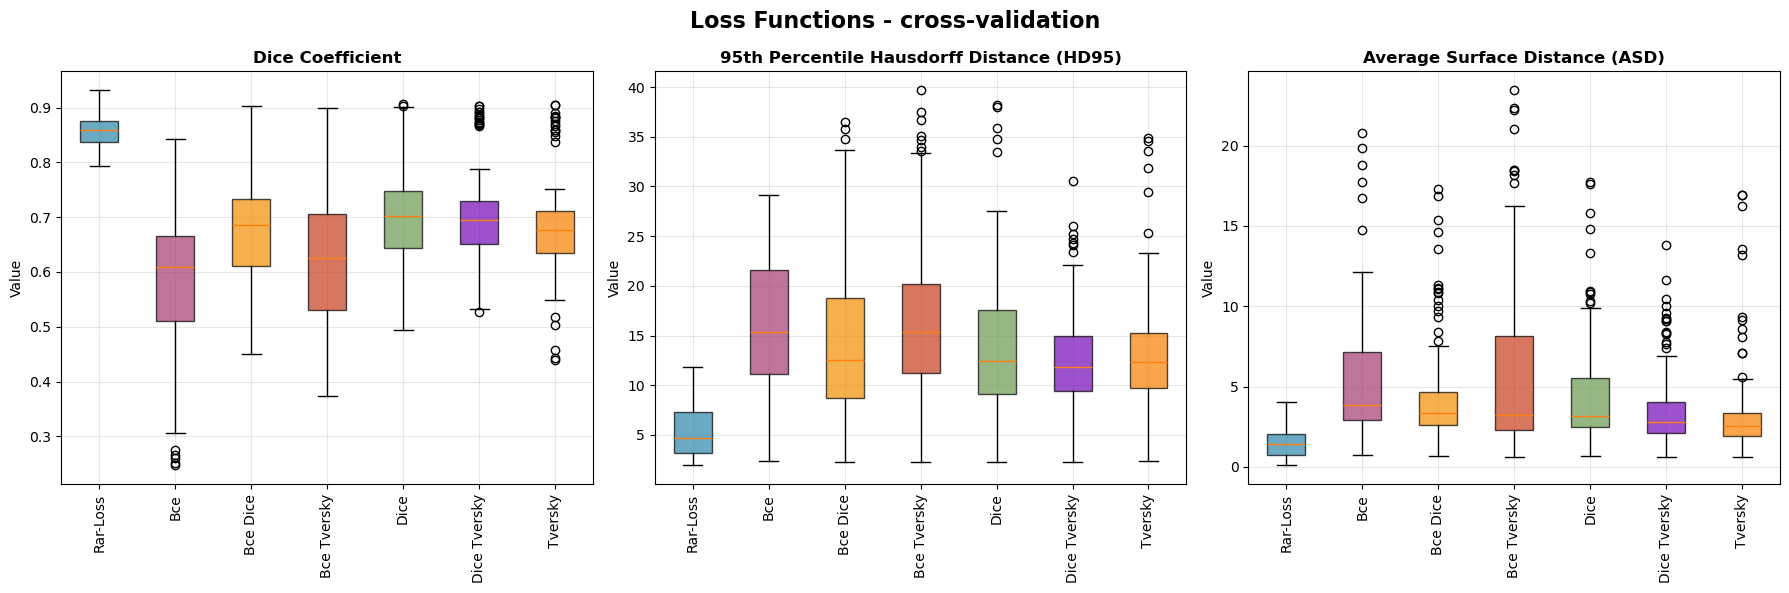

/tmp/ipykernel_3096476/489281056.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipykernel_3096476/489281056.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipykernel_3096476/489281056.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


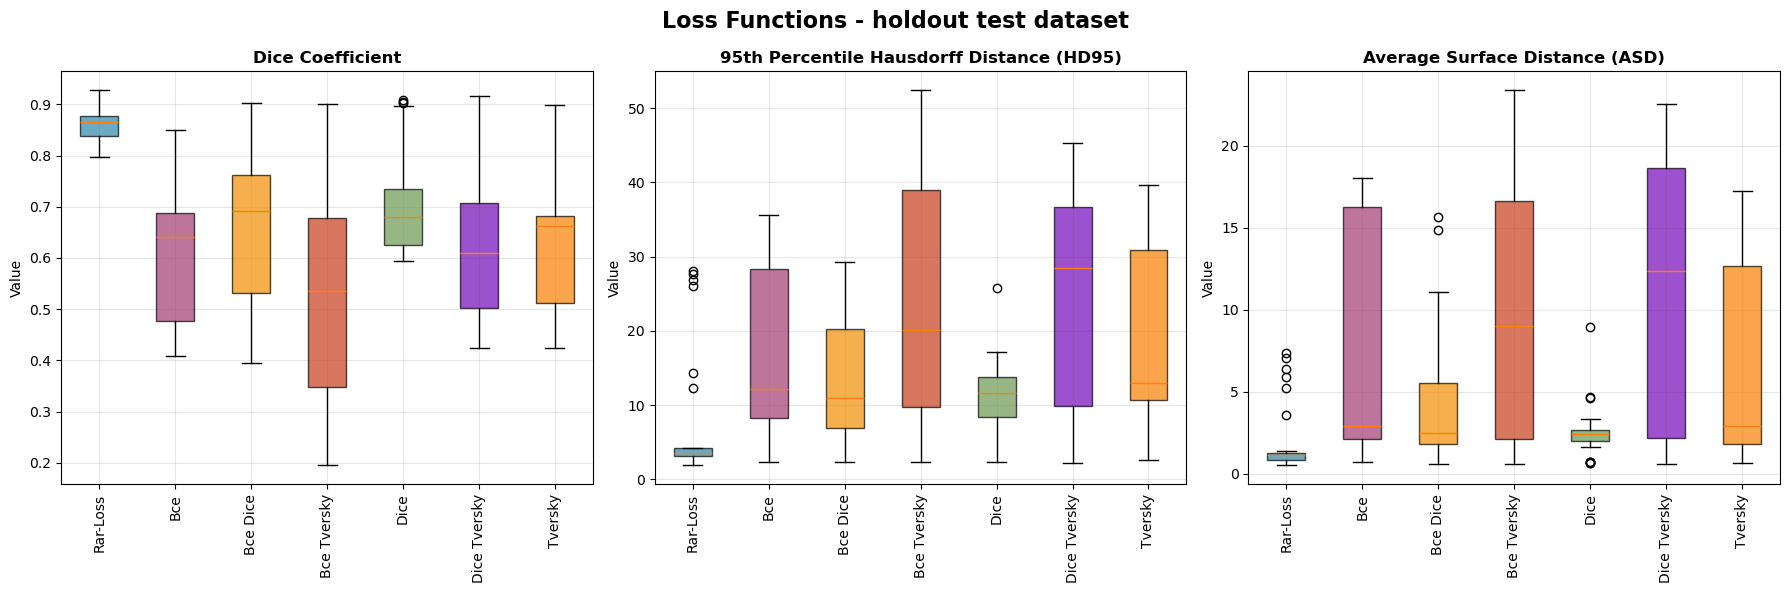

In [4]:
# Match the style of the reference notebook: simple matplotlib boxplots
plt.style.use("default")

metric_labels = {
    "hd95": "95th Percentile Hausdorff Distance (HD95)",
    "dice": "Dice Coefficient",
    "asd": "Average Surface Distance (ASD)",
}

colors = [
    "#2E86AB",
    "#A23B72",
    "#F18F01",
    "#C73E1D",
    "#6A994E",
    "#7209B7",
    "#F77F00",
]

for phase in ["cross-validation", "holdout test dataset"]:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(
        f"Loss Functions - {phase}",
        fontsize=16,
        fontweight="bold",
    )

    for idx, metric in enumerate(["dice", "hd95", "asd"]):
        ax = axes[idx]
        phase_df = all_df[(all_df["phase"] == phase) & (all_df["metric"] == metric)]
        if phase_df.empty:
            ax.axis("off")
            continue

        loss_order = sorted(phase_df["loss"].dropna().unique())
        plot_data = [
            phase_df.loc[phase_df["loss"] == loss, "mean"].dropna().values
            for loss in loss_order
        ]

        bp = ax.boxplot(
            plot_data,
            labels=[loss.replace("_", " ").title() for loss in loss_order],
            patch_artist=True,
            showfliers=True,
        )

        for patch, color in zip(bp["boxes"], colors[: len(plot_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.set_title(metric_labels[metric], fontsize=12, fontweight="bold")
        ax.set_ylabel("Value", fontsize=10)
        ax.tick_params(axis="x", rotation=90)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

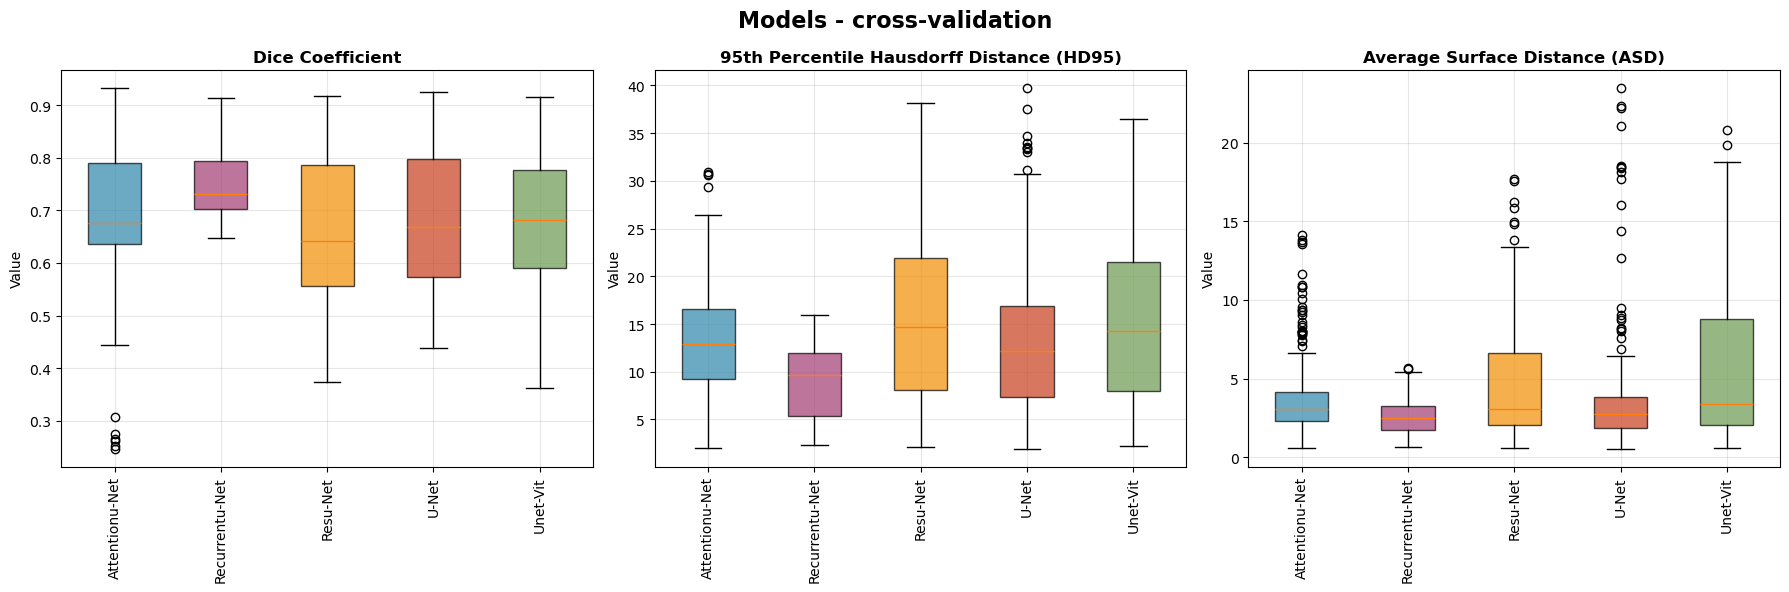

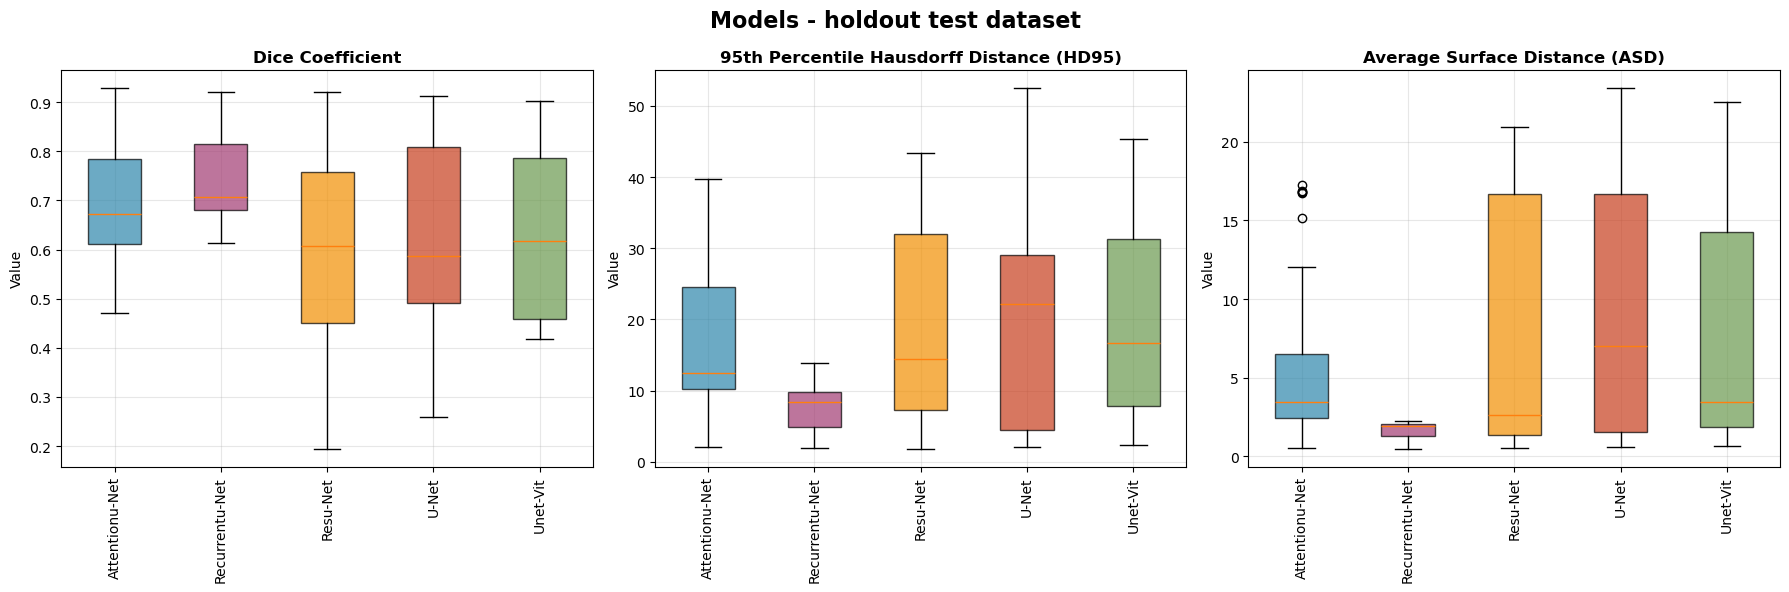

In [ ]:
plt.style.use("default")

for phase in ["cross-validation", "holdout test dataset"]:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Models - {phase}", fontsize=16, fontweight="bold")

    for idx, metric in enumerate(["dice", "hd95", "asd"]):
        ax = axes[idx]
        phase_df = all_df[(all_df["phase"] == phase) & (all_df["metric"] == metric)]
        if phase_df.empty:
            ax.axis("off")
            continue

        model_order = sorted(phase_df["model"].dropna().unique())
        plot_data = [phase_df.loc[phase_df["model"] == model, "mean"].dropna().values for model in model_order]

        bp = ax.boxplot(
            plot_data,
            tick_labels=[model.replace("_", " ").title() for model in model_order],
            patch_artist=True,
            showfliers=True,
        )

        for patch, color in zip(bp["boxes"], colors[: len(plot_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.set_title(metric_labels[metric], fontsize=12, fontweight="bold")
        ax.set_ylabel("Value", fontsize=10)
        ax.tick_params(axis="x", rotation=90)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
FOLD_DATA_ROOT = "path/to/cv_folds"  
fold_x_test = np.load(f'{FOLD_DATA_ROOT}/fold_1/fold_1_X_val_3D.npy')
fold_y_test = np.load(f'{FOLD_DATA_ROOT}/fold_1/fold_1_y_val_3D.npy')
fold_y_test = (fold_y_test > 0.5).astype(np.float32)

# Apply PGD attack with 30 steps
EPSILON    = 0.10
STEPS      = 30
RESTARTS   = 1
STEP_SCALE = 1.0
step       = (STEP_SCALE * EPSILON) / float(STEPS)

np.random.seed(None)
patient_idx = np.random.randint(0, fold_x_test.shape[0])
slice_idx = 7  

print(f"Selected Patient Index: {patient_idx}")
print(f"Selected Slice Index: {slice_idx}")
print(f"Total patients in test set: {fold_x_test.shape[0]}")

x_sample = fold_x_test[patient_idx:patient_idx+1].astype(np.float32)
y_sample = fold_y_test[patient_idx:patient_idx+1].astype(np.float32)

Selected Patient Index: 36
Selected Slice Index: 7
Total patients in test set: 55


In [ ]:
f = 1

recurrent_unet_robust_model         = recurrent_unet_3d((15,256,256,1), use_sn=True)
recurrent_unet_bce_model            = recurrent_unet_3d((15,256,256,1), use_sn=True)
recurrent_unet_tversky_model        = recurrent_unet_3d((15,256,256,1), use_sn=True)
recurrent_unet_dice_model           = recurrent_unet_3d((15,256,256,1), use_sn=True)
recurrent_unet_bce_dice_model       = recurrent_unet_3d((15,256,256,1), use_sn=True)
recurrent_unet_bce_tversky_model    = recurrent_unet_3d((15,256,256,1), use_sn=True)
recurrent_unet_dice_tversky_model   = recurrent_unet_3d((15,256,256,1), use_sn=True)

recurrent_unet_robust_model.load_weights('path/to/weights')
recurrent_unet_bce_model.load_weights('path/to/weights')
recurrent_unet_tversky_model.load_weights(f'path/to/model/RecurrentUNet-Robust/Cross-Validation/Fold{f}/recurrent_unet_3d_tversky_fold{f}_final.weights.h5')
recurrent_unet_dice_model.load_weights(f'path/to/model/RecurrentUNet-Robust/Cross-Validation/Fold{f}/recurrent_unet_3d_dice_fold{f}_final.weights.h5')
recurrent_unet_bce_dice_model.load_weights(f'path/to/model/RecurrentUNet-Robust/Cross-Validation/Fold{f}/recurrent_unet_3d_bce_dice_fold{f}_final.weights.h5')
recurrent_unet_bce_tversky_model.load_weights(f'path/to/model/RecurrentUNet-Robust/Cross-Validation/Fold{f}/recurrent_unet_3d_bce_tversky_fold{f}_final.weights.h5')
recurrent_unet_dice_tversky_model.load_weights(f'path/to/model/RecurrentUNet-Robust/Cross-Validation/Fold{f}/recurrent_unet_3d_dice_tversky_fold{f}_final.weights.h5')

res_unet_robust_model       = load_model(f'path/to/model/ResUNet-Robust/Cross-Validation/Fold{f}/res_unet_3d_robust_dice_lambda_adv_1_lambda_gp_0.1_fold{f}_final_updated.keras',     custom_objects= custom_robust)
res_unet_bce_model          = load_model(f'path/to/model/ResUNet-Robust/Cross-Validation/Fold{f}/res_unet_3d_bce_fold{f}_final.keras',             custom_objects= {'dice_soft_from_logits'         : dice_soft_from_logits,         'GroupNormalization'   : GroupNormalization,    'SpectralNormalization': SpectralNormalization})
res_unet_tversky_model      = load_model(f'path/to/model/ResUNet-Robust/Cross-Validation/Fold{f}/res_unet_3d_tversky_fold{f}_final.keras',         custom_objects= {'tversky_from_logits'           : tversky_from_logits,           'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
res_unet_dice_model         = load_model(f'path/to/model/ResUNet-Robust/Cross-Validation/Fold{f}/res_unet_3d_dice_fold{f}_final.keras',            custom_objects= {'dice_loss_from_logits'         : dice_loss_from_logits,         'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
res_unet_bce_dice_model     = load_model(f'path/to/model/ResUNet-Robust/Cross-Validation/Fold{f}/res_unet_3d_bce_dice_fold{f}_final.keras',        custom_objects= {'bce_dice_loss_from_logits'     : bce_dice_loss_from_logits,     'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
res_unet_bce_tversky_model  = load_model(f'path/to/model/ResUNet-Robust/Cross-Validation/Fold{f}/res_unet_3d_bce_tversky_fold{f}_final.keras',     custom_objects= {'bce_tversky_loss_from_logits'  : bce_tversky_loss_from_logits,  'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
res_unet_dice_tversky_model = load_model(f'path/to/model/ResUNet-Robust/Cross-Validation/Fold{f}/res_unet_3d_dice_tversky_fold{f}_final.keras',    custom_objects= {'dice_tversky_loss_from_logits' : dice_tversky_loss_from_logits, 'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})

unet_robust_model       = load_model(f'path/to/model/UNet-Robust/Cross-Validation/Fold{f}/unet_3d_robust_dice_lambda_adv_1_lambda_gp_0.1_fold{f}_final_updated.keras',     custom_objects= custom_robust)
unet_bce_model          = load_model(f'path/to/model/UNet-Robust/Cross-Validation/Fold{f}/unet_3d_bce_fold{f}_final.keras',             custom_objects= {'dice_soft_from_logits'         : dice_soft_from_logits,         'GroupNormalization'   : GroupNormalization,    'SpectralNormalization': SpectralNormalization})
unet_tversky_model      = load_model(f'path/to/model/UNet-Robust/Cross-Validation/Fold{f}/unet_3d_tversky_fold{f}_final.keras',         custom_objects= {'tversky_from_logits'           : tversky_from_logits,           'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
unet_dice_model         = load_model(f'path/to/model/UNet-Robust/Cross-Validation/Fold{f}/unet_3d_dice_fold{f}_final.keras',            custom_objects= {'dice_loss_from_logits'         : dice_loss_from_logits,         'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
unet_bce_dice_model     = load_model(f'path/to/model/UNet-Robust/Cross-Validation/Fold{f}/unet_3d_bce_dice_fold{f}_final.keras',        custom_objects= {'bce_dice_loss_from_logits'     : bce_dice_loss_from_logits,     'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
unet_bce_tversky_model  = load_model(f'path/to/model/UNet-Robust/Cross-Validation/Fold{f}/unet_3d_bce_tversky_fold{f}_final.keras',     custom_objects= {'bce_tversky_loss_from_logits'  : bce_tversky_loss_from_logits,  'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
unet_dice_tversky_model = load_model(f'path/to/model/UNet-Robust/Cross-Validation/Fold{f}/unet_3d_dice_tversky_fold{f}_final.keras',    custom_objects= {'dice_tversky_loss_from_logits' : dice_tversky_loss_from_logits, 'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})

attention_unet_robust_model       = load_model(f'path/to/model/AttentionUNet-Robust/Cross-Validation/Fold{f}/attention_unet_3d_robust_dice_lambda_adv_1_lambda_gp_0.1_fold{f}_final_updated.keras',     custom_objects= custom_robust)
attention_unet_bce_model          = load_model(f'path/to/model/AttentionUNet-Robust/Cross-Validation/Fold{f}/attention_unet_3d_bce_fold{f}_final.keras',             custom_objects= {'dice_soft_from_logits'         : dice_soft_from_logits,         'GroupNormalization'   : GroupNormalization,    'SpectralNormalization': SpectralNormalization})
attention_unet_tversky_model      = load_model(f'path/to/model/AttentionUNet-Robust/Cross-Validation/Fold{f}/attention_unet_3d_tversky_fold{f}_final.keras',         custom_objects= {'tversky_from_logits'           : tversky_from_logits,           'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
attention_unet_dice_model         = load_model(f'path/to/model/AttentionUNet-Robust/Cross-Validation/Fold{f}/attention_unet_3d_dice_fold{f}_final.keras',            custom_objects= {'dice_loss_from_logits'         : dice_loss_from_logits,         'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
attention_unet_bce_dice_model     = load_model(f'path/to/model/AttentionUNet-Robust/Cross-Validation/Fold{f}/attention_unet_3d_bce_dice_fold{f}_final.keras',        custom_objects= {'bce_dice_loss_from_logits'     : bce_dice_loss_from_logits,     'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
attention_unet_bce_tversky_model  = load_model(f'path/to/model/AttentionUNet-Robust/Cross-Validation/Fold{f}/attention_unet_3d_bce_tversky_fold{f}_final.keras',     custom_objects= {'bce_tversky_loss_from_logits'  : bce_tversky_loss_from_logits,  'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
attention_unet_dice_tversky_model = load_model(f'path/to/model/AttentionUNet-Robust/Cross-Validation/Fold{f}/attention_unet_3d_dice_tversky_fold{f}_final.keras',    custom_objects= {'dice_tversky_loss_from_logits' : dice_tversky_loss_from_logits, 'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})

vit_unet_robust_model       = load_model(f'path/to/model/ViT-UNet-Robust/Cross-Validation/Fold{f}/unet_vit_3d_robust_dice_lambda_adv_1_lambda_gp_0.5_fold{f}_final_updated.keras',     custom_objects= custom_robust_vit)
vit_unet_bce_model          = load_model(f'path/to/model/ViT-UNet-Robust/Cross-Validation/Fold{f}/unet_vit_3d_bce_fold{f}_final.keras',             custom_objects= {'dice_soft_from_logits'         : dice_soft_from_logits,         'GroupNormalization'   : GroupNormalization,    'SpectralNormalization': SpectralNormalization})
vit_unet_tversky_model      = load_model(f'path/to/model/ViT-UNet-Robust/Cross-Validation/Fold{f}/unet_vit_3d_tversky_fold{f}_final.keras',         custom_objects= {'tversky_from_logits'           : tversky_from_logits,           'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
vit_unet_dice_model         = load_model(f'path/to/model/ViT-UNet-Robust/Cross-Validation/Fold{f}/unet_vit_3d_dice_fold{f}_final.keras',            custom_objects= {'dice_loss_from_logits'         : dice_loss_from_logits,         'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
vit_unet_bce_dice_model     = load_model(f'path/to/model/ViT-UNet-Robust/Cross-Validation/Fold{f}/unet_vit_3d_bce_dice_fold{f}_final.keras',        custom_objects= {'bce_dice_loss_from_logits'     : bce_dice_loss_from_logits,     'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
vit_unet_bce_tversky_model  = load_model(f'path/to/model/ViT-UNet-Robust/Cross-Validation/Fold{f}/unet_vit_3d_bce_tversky_fold{f}_final.keras',     custom_objects= {'bce_tversky_loss_from_logits'  : bce_tversky_loss_from_logits,  'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})
vit_unet_dice_tversky_model = load_model(f'path/to/model/ViT-UNet-Robust/Cross-Validation/Fold{f}/unet_vit_3d_dice_tversky_fold{f}_final.keras',    custom_objects= {'dice_tversky_loss_from_logits' : dice_tversky_loss_from_logits, 'dice_soft_from_logits': dice_soft_from_logits, 'GroupNormalization': GroupNormalization, 'SpectralNormalization': SpectralNormalization})

In [ ]:
# Get predictions from all models (they output logits, need sigmoid)
def get_prediction(model, x):
    logits = model(x, training=False)
    pred = tf.nn.sigmoid(tf.cast(logits, tf.float32)).numpy()
    return (pred > 0.5).astype(np.float32)

# RecurrentUNet predictions
recurrent_unet_preds = {
    'RAR-Loss'      : get_prediction(recurrent_unet_robust_model,       x_sample),
    'BCE'           : get_prediction(recurrent_unet_bce_model,          x_sample),
    'Tversky'       : get_prediction(recurrent_unet_tversky_model,      x_sample),
    'Dice'          : get_prediction(recurrent_unet_dice_model,         x_sample),
    'BCE+Dice'      : get_prediction(recurrent_unet_bce_dice_model,     x_sample),
    'BCE+Tversky'   : get_prediction(recurrent_unet_bce_tversky_model,  x_sample),
    'Dice+Tversky'  : get_prediction(recurrent_unet_dice_tversky_model, x_sample),
}

# ResUNet predictions
res_unet_preds = {
    'RAR-Loss'              : get_prediction(res_unet_robust_model,       x_sample),
    'BCE'                   : get_prediction(res_unet_bce_model,          x_sample),
    'Tversky'               : get_prediction(res_unet_tversky_model,      x_sample),
    'Dice'                  : get_prediction(res_unet_dice_model,         x_sample),
    'BCE+Dice'              : get_prediction(res_unet_bce_dice_model,     x_sample),
    'BCE+Tversky'           : get_prediction(res_unet_bce_tversky_model,  x_sample),
    'Dice+Tversky'          : get_prediction(res_unet_dice_tversky_model, x_sample),
}

# UNet predictions
unet_preds = {
    'RAR-Loss'              : get_prediction(unet_robust_model,       x_sample),
    'BCE'                   : get_prediction(unet_bce_model,          x_sample),
    'Tversky'               : get_prediction(unet_tversky_model,      x_sample),
    'Dice'                  : get_prediction(unet_dice_model,         x_sample),
    'BCE+Dice'              : get_prediction(unet_bce_dice_model,     x_sample),
    'BCE+Tversky'           : get_prediction(unet_bce_tversky_model,  x_sample),
    'Dice+Tversky'          : get_prediction(unet_dice_tversky_model, x_sample),
}

# AttentionUNet predictions
attention_unet_preds = {
    'RAR-Loss'              : get_prediction(attention_unet_robust_model,       x_sample),
    'BCE'                   : get_prediction(attention_unet_bce_model,          x_sample),
    'Tversky'               : get_prediction(attention_unet_tversky_model,      x_sample),
    'Dice'                  : get_prediction(attention_unet_dice_model,         x_sample),
    'BCE+Dice'              : get_prediction(attention_unet_bce_dice_model,     x_sample),
    'BCE+Tversky'           : get_prediction(attention_unet_bce_tversky_model,  x_sample),
    'Dice+Tversky'          : get_prediction(attention_unet_dice_tversky_model, x_sample),
}

# ViT-UNet predictions
vit_unet_preds = {
    'RAR-Loss'              : get_prediction(vit_unet_robust_model,       x_sample),
    'BCE'                   : get_prediction(vit_unet_bce_model,          x_sample),
    'Tversky'               : get_prediction(vit_unet_tversky_model,      x_sample),
    'Dice'                  : get_prediction(vit_unet_dice_model,         x_sample),
    'BCE+Dice'              : get_prediction(vit_unet_bce_dice_model,     x_sample),
    'BCE+Tversky'           : get_prediction(vit_unet_bce_tversky_model,  x_sample),
    'Dice+Tversky'          : get_prediction(vit_unet_dice_tversky_model, x_sample),
}

print("Predictions computed successfully!")

In [ ]:
def generate_adversarial(model, x, y, eps, step, steps, restarts):
    x_adv = pgd_bce_attack(model, x, y, eps, step, steps, restarts)
    return x_adv.numpy()

print("\nGenerating adversarial examples for RecurrentUNet...")
recurrent_unet_adv = {
    'RAR-Loss'      : generate_adversarial(recurrent_unet_robust_model,       x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE'           : generate_adversarial(recurrent_unet_bce_model,          x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Tversky'       : generate_adversarial(recurrent_unet_tversky_model,      x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Dice'          : generate_adversarial(recurrent_unet_dice_model,         x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE+Dice'      : generate_adversarial(recurrent_unet_bce_dice_model,     x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE+Tversky'   : generate_adversarial(recurrent_unet_bce_tversky_model,  x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Dice+Tversky'  : generate_adversarial(recurrent_unet_dice_tversky_model, x_sample, y_sample, EPSILON, step, STEPS, RESTARTS)}

print("Generating adversarial examples for ResUNet...")
res_unet_adv = {
    'RAR-Loss'      : generate_adversarial(res_unet_robust_model,           x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE'           : generate_adversarial(res_unet_bce_model,              x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Tversky'       : generate_adversarial(res_unet_tversky_model,          x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Dice'          : generate_adversarial(res_unet_dice_model,             x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE+Dice'      : generate_adversarial(res_unet_bce_dice_model,         x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE+Tversky'   : generate_adversarial(res_unet_bce_tversky_model,      x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Dice+Tversky'  : generate_adversarial(res_unet_dice_tversky_model,     x_sample, y_sample, EPSILON, step, STEPS, RESTARTS)}

print("Generating adversarial examples for Attention UNet...")
attention_unet_adv = {
    'RAR-Loss'      : generate_adversarial(attention_unet_robust_model,           x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE'           : generate_adversarial(attention_unet_bce_model,              x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Tversky'       : generate_adversarial(attention_unet_tversky_model,          x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Dice'          : generate_adversarial(attention_unet_dice_model,             x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE+Dice'      : generate_adversarial(attention_unet_bce_dice_model,         x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE+Tversky'   : generate_adversarial(attention_unet_bce_tversky_model,      x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Dice+Tversky'  : generate_adversarial(attention_unet_dice_tversky_model,     x_sample, y_sample, EPSILON, step, STEPS, RESTARTS)}

print("Generating adversarial examples for UNet...")
unet_adv = {
    'RAR-Loss'      : generate_adversarial(unet_robust_model,           x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE'           : generate_adversarial(unet_bce_model,              x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Tversky'       : generate_adversarial(unet_tversky_model,          x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Dice'          : generate_adversarial(unet_dice_model,             x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE+Dice'      : generate_adversarial(unet_bce_dice_model,         x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE+Tversky'   : generate_adversarial(unet_bce_tversky_model,      x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Dice+Tversky'  : generate_adversarial(unet_dice_tversky_model,     x_sample, y_sample, EPSILON, step, STEPS, RESTARTS)}

print("Generating adversarial examples for ViT UNet...")
vit_unet_adv = {
    'RAR-Loss'      : generate_adversarial(vit_unet_robust_model,           x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE'           : generate_adversarial(vit_unet_bce_model,              x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Tversky'       : generate_adversarial(vit_unet_tversky_model,          x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Dice'          : generate_adversarial(vit_unet_dice_model,             x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE+Dice'      : generate_adversarial(vit_unet_bce_dice_model,         x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'BCE+Tversky'   : generate_adversarial(vit_unet_bce_tversky_model,      x_sample, y_sample, EPSILON, step, STEPS, RESTARTS),
    'Dice+Tversky'  : generate_adversarial(vit_unet_dice_tversky_model,     x_sample, y_sample, EPSILON, step, STEPS, RESTARTS)}   

print("Adversarial examples generated successfully!")

In [ ]:
print("Computing predictions on adversarial examples...")

recurrent_unet_adv_preds = {
    loss_name: get_prediction(model, recurrent_unet_adv[loss_name])
    for loss_name, model in [
        ('RAR-Loss',    recurrent_unet_robust_model),
        ('BCE',         recurrent_unet_bce_model),
        ('Tversky',     recurrent_unet_tversky_model),
        ('Dice',        recurrent_unet_dice_model),
        ('BCE+Dice',    recurrent_unet_bce_dice_model),
        ('BCE+Tversky', recurrent_unet_bce_tversky_model),
        ('Dice+Tversky',recurrent_unet_dice_tversky_model),
    ]
}

res_unet_adv_preds = {
    loss_name: get_prediction(model, res_unet_adv[loss_name])
    for loss_name, model in [
        ('RAR-Loss',    res_unet_robust_model),
        ('BCE',         res_unet_bce_model),
        ('Tversky',     res_unet_tversky_model),
        ('Dice',        res_unet_dice_model),
        ('BCE+Dice',    res_unet_bce_dice_model),
        ('BCE+Tversky', res_unet_bce_tversky_model),
        ('Dice+Tversky',res_unet_dice_tversky_model),
    ]
}

unet_adv_preds = {
    loss_name: get_prediction(model, unet_adv[loss_name])
    for loss_name, model in [
        ('RAR-Loss',    unet_robust_model),
        ('BCE',         unet_bce_model),
        ('Tversky',     unet_tversky_model),
        ('Dice',        unet_dice_model),
        ('BCE+Dice',    unet_bce_dice_model),
        ('BCE+Tversky', unet_bce_tversky_model),
        ('Dice+Tversky',unet_dice_tversky_model),
    ]
}

attention_unet_adv_preds = {
    loss_name: get_prediction(model, attention_unet_adv[loss_name])
    for loss_name, model in [
        ('RAR-Loss',    attention_unet_robust_model),
        ('BCE',         attention_unet_bce_model),
        ('Tversky',     attention_unet_tversky_model),
        ('Dice',        attention_unet_dice_model),
        ('BCE+Dice',    attention_unet_bce_dice_model),
        ('BCE+Tversky', attention_unet_bce_tversky_model),
        ('Dice+Tversky',attention_unet_dice_tversky_model),
    ]
}

vit_unet_adv_preds = {
    loss_name: get_prediction(model, vit_unet_adv[loss_name])
    for loss_name, model in [
        ('RAR-Loss',    vit_unet_robust_model),
        ('BCE',         vit_unet_bce_model),
        ('Tversky',     vit_unet_tversky_model),
        ('Dice',        vit_unet_dice_model),
        ('BCE+Dice',    vit_unet_bce_dice_model),
        ('BCE+Tversky', vit_unet_bce_tversky_model),
        ('Dice+Tversky',vit_unet_dice_tversky_model),
    ]
}

print("Adversarial predictions computed successfully!")

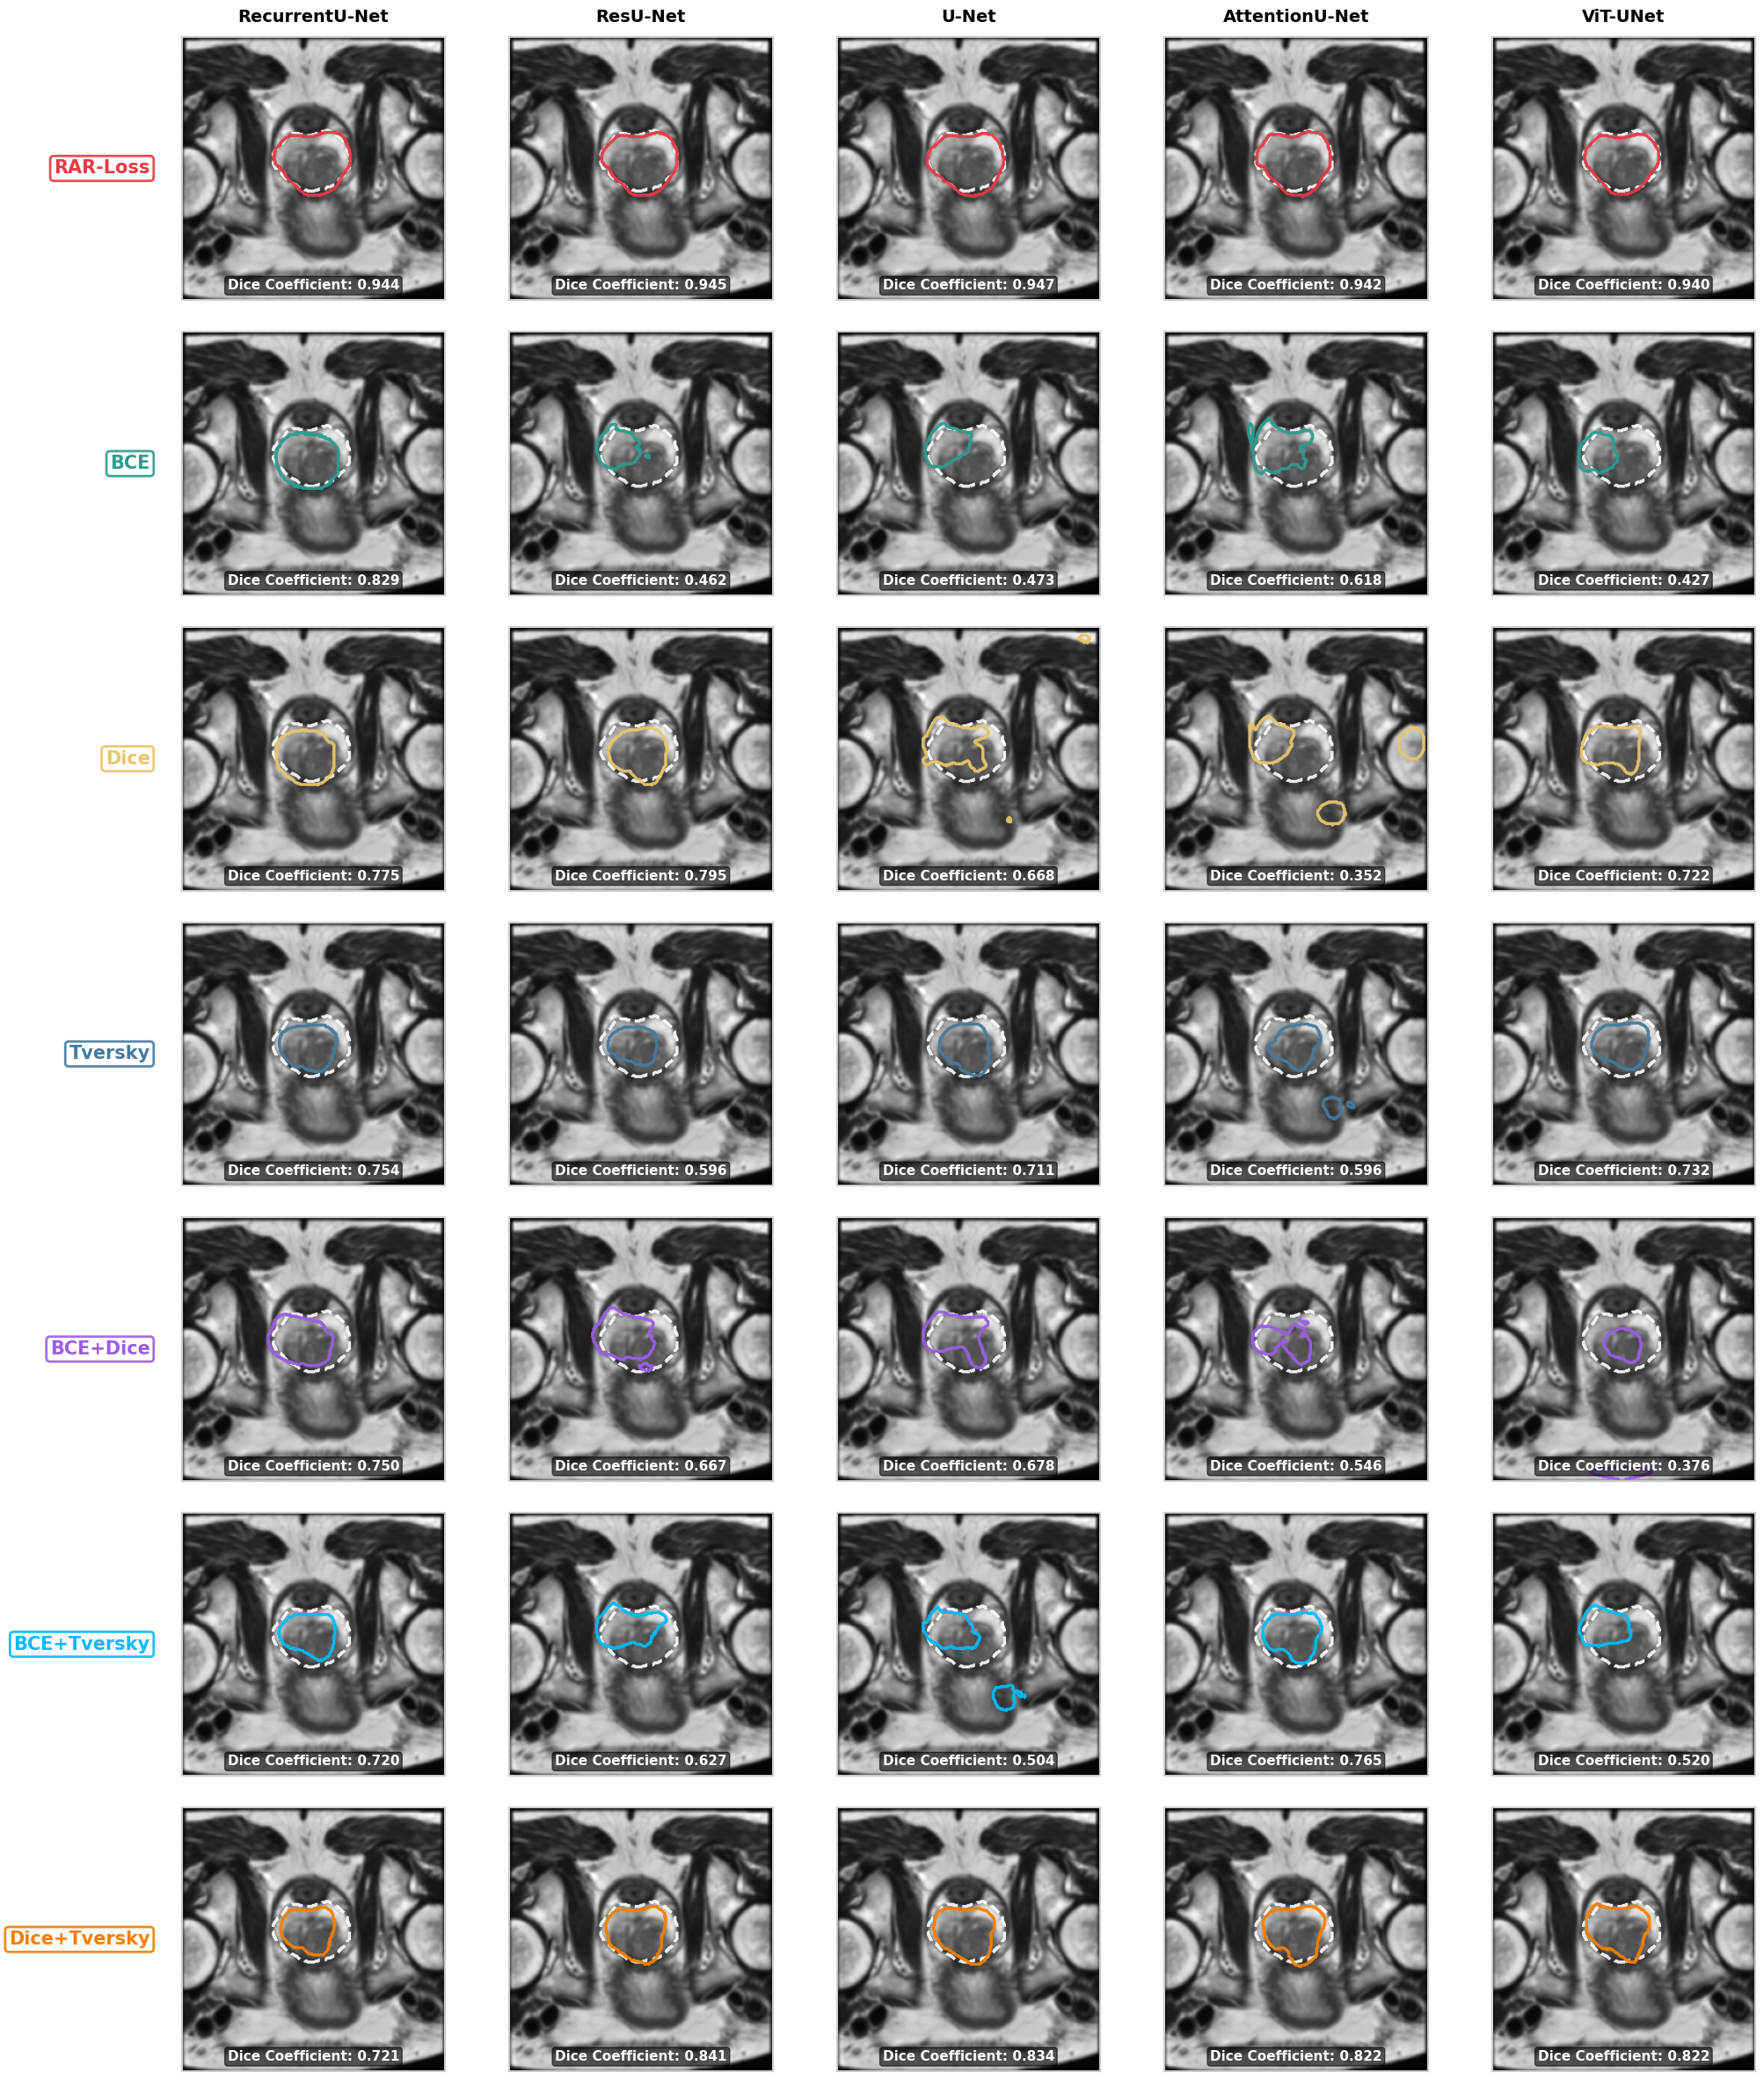


Saved as 'adversarial_grid_predictions.png'


In [ ]:
def plot_adversarial_grid(x_sample, y_sample, model_adv_dict, model_preds_dict, slice_idx, figsize=(26, 30)):
    gt_slice = y_sample[0, slice_idx, :, :, 0]
    img_clean = x_sample[0, slice_idx, :, :, 0]
    
    # Define order
    loss_names = ['RAR-Loss', 'BCE', 'Dice', 'Tversky', 'BCE+Dice', 'BCE+Tversky', 'Dice+Tversky']
    model_names = list(model_adv_dict.keys())
    
    n_losses = len(loss_names)
    n_models = len(model_names)
    
    colors = {
        'RAR-Loss': '#E63946',
        'BCE': '#2A9D8F',
        'Dice': '#E9C46A',
        'Tversky': '#457B9D',
        'BCE+Dice': '#9B5DE5',
        'BCE+Tversky': '#00BBF9',
        'Dice+Tversky': '#F77F00',
    }
    
    fig, axes = plt.subplots(n_losses, n_models, figsize=figsize, facecolor='white')
    fig.patch.set_facecolor('white')
    
    for row, loss_name in enumerate(loss_names):
        for col, model_name in enumerate(model_names):
            ax = axes[row, col]
            ax.set_facecolor('white')
            
            if loss_name in model_preds_dict[model_name] and loss_name in model_adv_dict[model_name]:
                pred_adv = model_preds_dict[model_name][loss_name][0, slice_idx, :, :, 0]
                
                ax.imshow(img_clean, cmap='gray', vmin=img_clean.min(), vmax=img_clean.max())
                
                if gt_slice.max() > 0:
                    contours = measure.find_contours(gt_slice, 0.5)
                    for contour in contours:
                        ax.plot(contour[:, 1], contour[:, 0], '--', color='white', 
                               linewidth=2.5, alpha=0.9)
                
                if pred_adv.max() > 0:
                    contours = measure.find_contours(pred_adv, 0.5)
                    for contour in contours:
                        ax.plot(contour[:, 1], contour[:, 0], '-', color=colors[loss_name], 
                               linewidth=2.5, alpha=0.95)
                
                dice_adv = (2 * np.sum(gt_slice * pred_adv) + 1e-6) / (np.sum(gt_slice) + np.sum(pred_adv) + 1e-6)
                
                ax.text(0.5, 0.03, f'Dice Coefficient: {dice_adv:.3f}', transform=ax.transAxes,
                       ha='center', va='bottom', fontsize=11, fontweight='bold', color='white',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.6))
            else:
                ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes, ha='center', va='center',
                       fontsize=12, color='#666666', fontweight='bold')
            
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color('#cccccc')
                spine.set_linewidth(1.5)
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            if col == 0:
                ax.text(-0.12, 0.5, loss_name, transform=ax.transAxes, fontsize=15, fontweight='bold',
                       rotation=0, ha='right', va='center', color=colors[loss_name],
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9,
                                edgecolor=colors[loss_name], linewidth=2))
            
            if row == 0:
                ax.set_title(model_name, fontsize=14, fontweight='bold', pad=12, color='black',
                            fontfamily='sans-serif')
    
    plt.tight_layout(rect=[0.08, 0.01, 1, 0.96])
    plt.subplots_adjust(wspace=0.08, hspace=0.12)
    plt.savefig('adversarial_grid_predictions.png', dpi=200, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    print("\nSaved as 'adversarial_grid_predictions.png'")

model_adv_dict = {
    'RecurrentU-Net': recurrent_unet_adv,
    'ResU-Net': res_unet_adv,
    'U-Net': unet_adv,
    'AttentionU-Net': attention_unet_adv,
    'ViT-UNet': vit_unet_adv,
}

model_adv_preds_dict = {
    'RecurrentU-Net': recurrent_unet_adv_preds,
    'ResU-Net': res_unet_adv_preds,
    'U-Net': unet_adv_preds,
    'AttentionU-Net': attention_unet_adv_preds,
    'ViT-UNet': vit_unet_adv_preds,
}

plot_adversarial_grid(
    x_sample, y_sample, 
    model_adv_dict, 
    model_adv_preds_dict, 
    slice_idx,
    figsize=(22, 25)
)

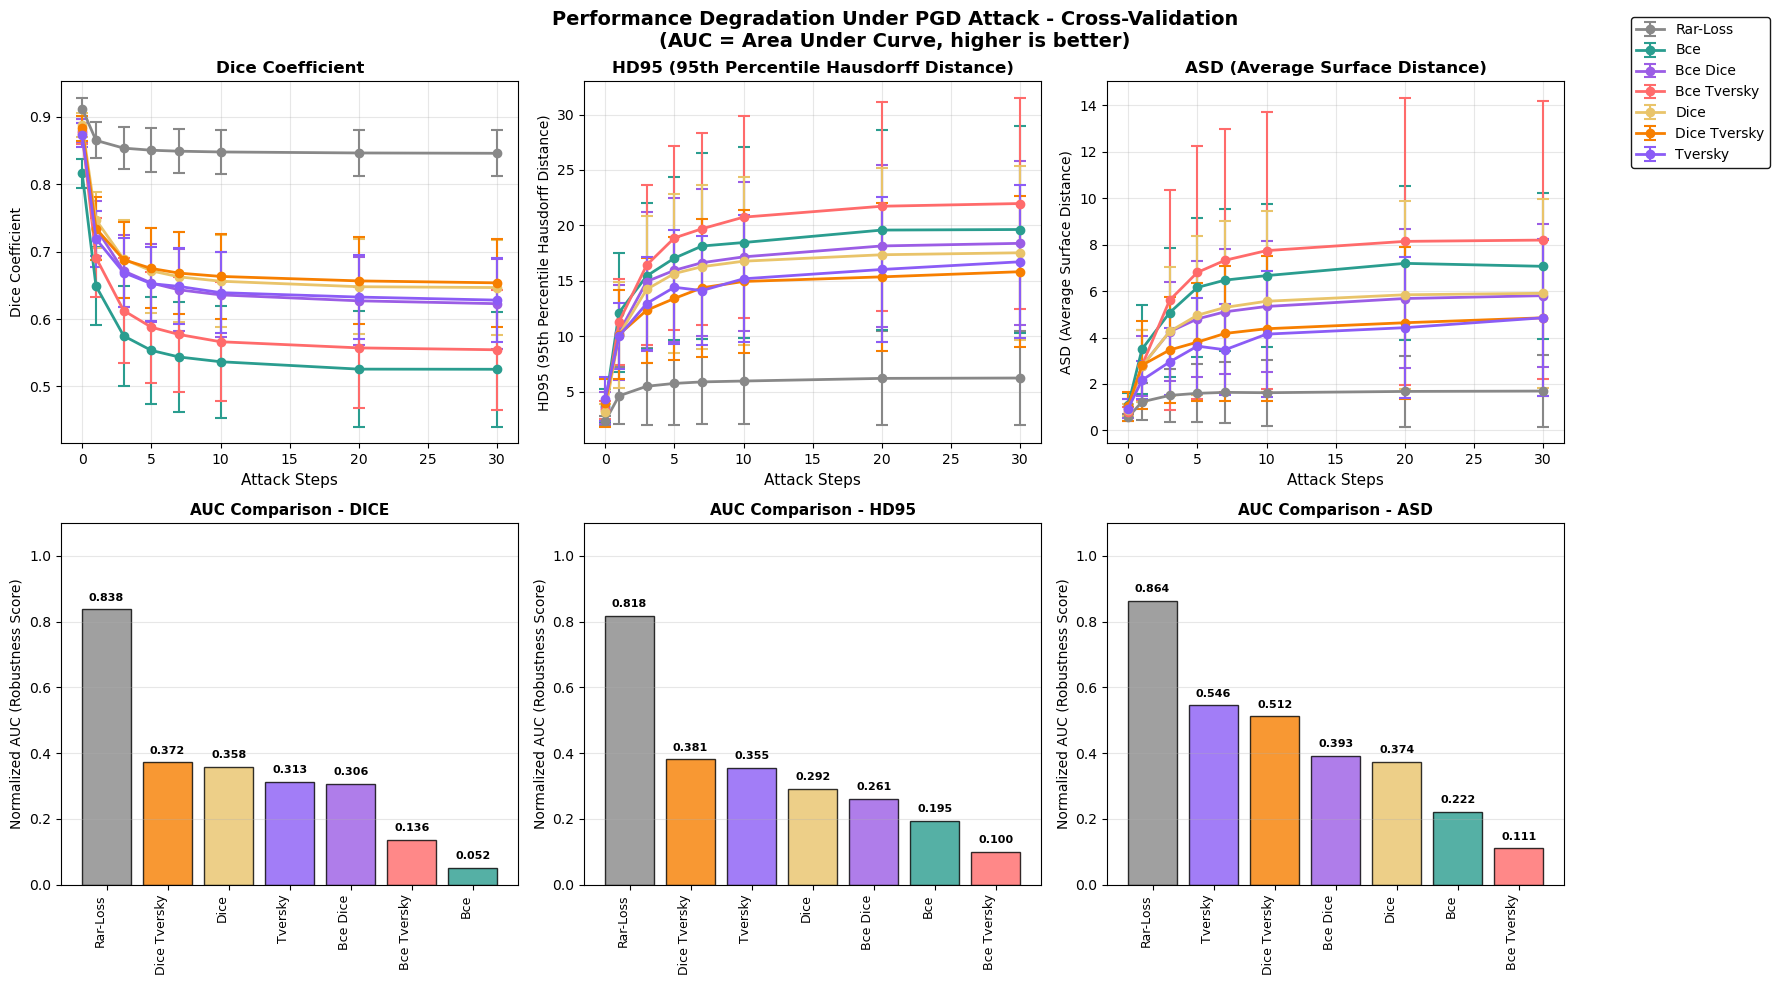

Saved auc_degradation_plot_cross-validation.png


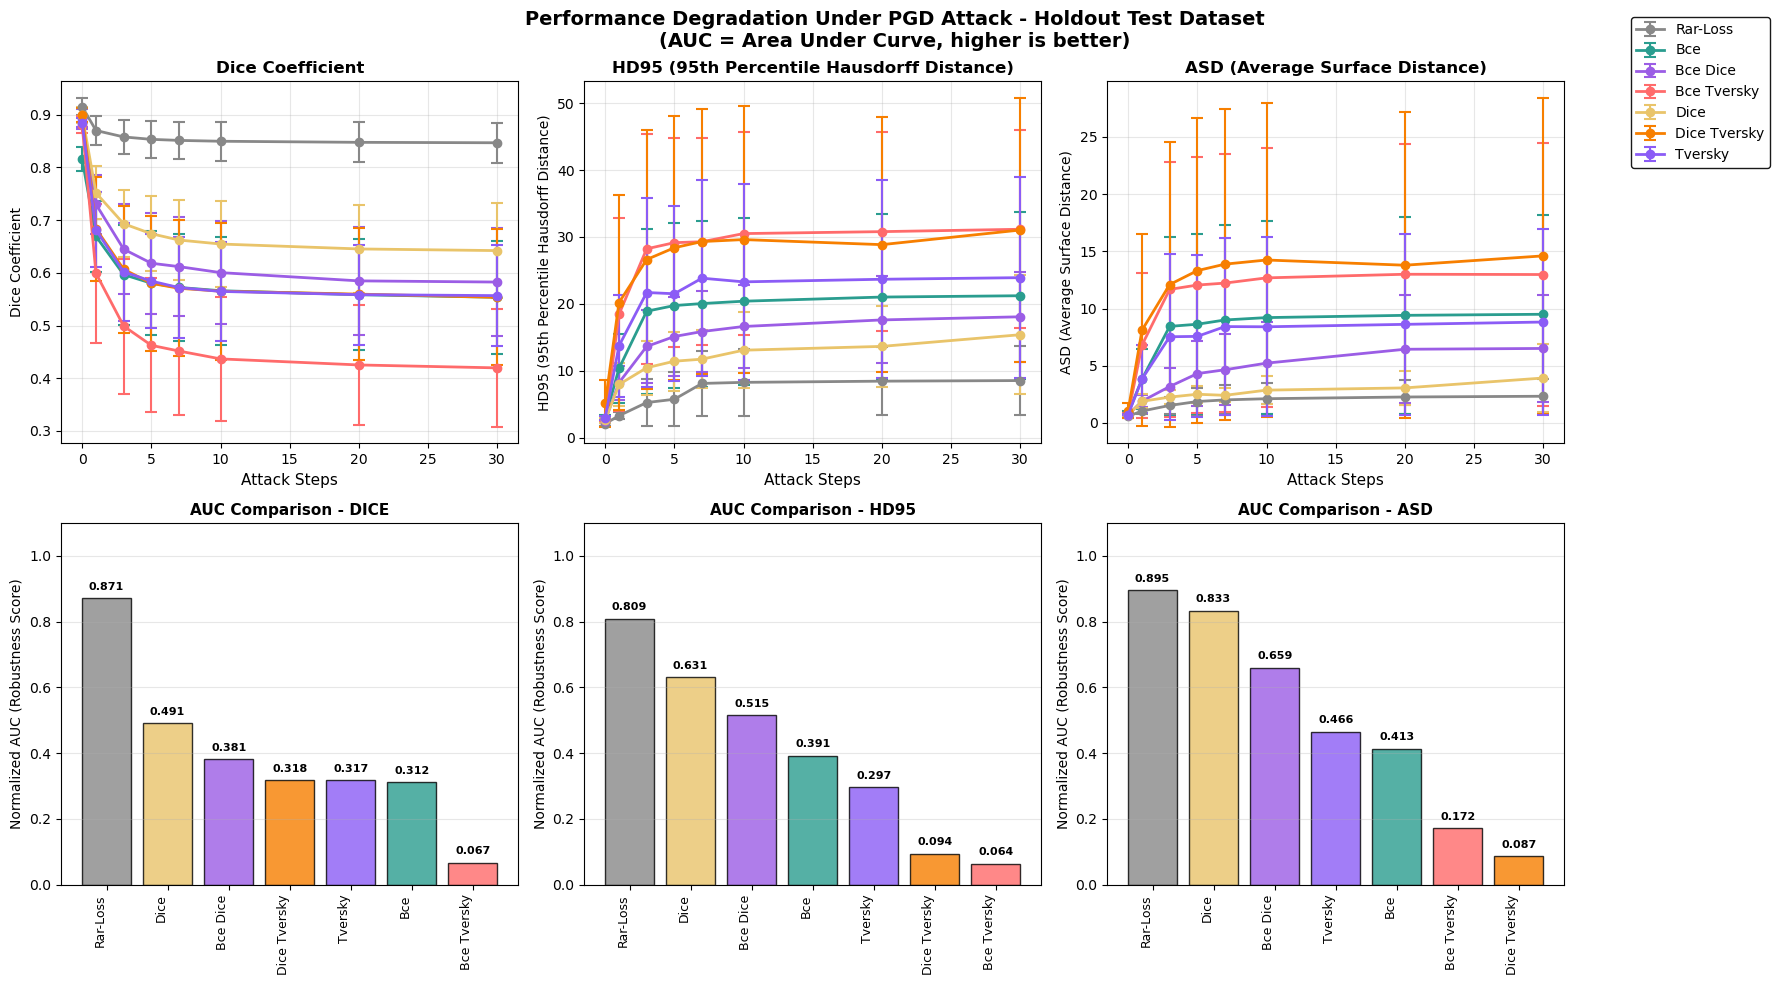

Saved auc_degradation_plot_holdout_test_dataset.png


In [ ]:
from sklearn.metrics import auc
import numpy as np

loss_colors = {
    'rar_loss': '#E63946',
    'bce': '#2A9D8F',
    'dice': '#E9C46A',
    'tversky': '#8B5CF6',
    'bce_dice': '#9B5DE5',
    'bce_tversky': '#FF6B6B',
    'dice_tversky': '#F77F00',
}

metric_labels = {
    "dice": "Dice Coefficient",
    "hd95": "HD95 (95th Percentile Hausdorff Distance)",
    "asd": "ASD (Average Surface Distance)"
}

for phase in ["cross-validation", "holdout test dataset"]:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Performance Degradation Under PGD Attack - {phase.title()}\n(AUC = Area Under Curve, higher is better)', 
                 fontsize=14, fontweight='bold')
    
    phase_df = all_df[all_df["phase"] == phase]
    
    if phase_df.empty:
        print(f"No data for {phase}")
        continue
    
    losses = sorted(phase_df["loss"].dropna().unique())
    
    for col, metric in enumerate(["dice", "hd95", "asd"]):
        ax_curve = axes[0, col]
        ax_auc = axes[1, col]
        
        metric_df = phase_df[phase_df["metric"] == metric]
        steps = sorted(metric_df["steps"].dropna().unique())
        
        loss_data = {}
        global_min = float('inf')
        global_max = float('-inf')
        
        for loss in losses:
            loss_df = metric_df[metric_df["loss"] == loss]
            
            step_means = []
            step_sems = []
            valid_steps = []
            for step in steps:
                step_data = loss_df[loss_df["steps"] == step]
                step_val = step_data["mean"].mean()
                if "sem" in step_data.columns:
                    sem_values = pd.to_numeric(step_data["sem"], errors='coerce')
                    step_sem = sem_values.mean()
                else:
                    step_sem = 0
                if not np.isnan(step_val):
                    step_means.append(step_val)
                    step_sems.append(step_sem if not np.isnan(step_sem) else 0)
                    valid_steps.append(step)
            
            if len(valid_steps) >= 2:
                loss_data[loss] = {'steps': valid_steps, 'means': step_means, 'sems': step_sems}
                global_min = min(global_min, min(step_means))
                global_max = max(global_max, max(step_means))
        
        auc_values = {}
        
        for loss, data in loss_data.items():
            valid_steps = data['steps']
            step_means = data['means']
            step_sems = data['sems']
            
            color = loss_colors.get(loss, '#888888')
            
            ci_95 = [1.96 * sem for sem in step_sems]
            
            ax_curve.errorbar(valid_steps, step_means, yerr=ci_95, fmt='o-', color=color, 
                             linewidth=2, markersize=6, capsize=4, capthick=1.5, elinewidth=1.5,
                             label=loss.replace('_', ' ').title())
            
            steps_norm = np.array(valid_steps) / max(valid_steps)
            
            if metric == "dice":
                if global_max > global_min:
                    normalized_means = [(v - global_min) / (global_max - global_min) for v in step_means]
                else:
                    normalized_means = step_means
                auc_val = auc(steps_norm, normalized_means)
            else:
                if global_max > global_min:
                    inverted_means = [(global_max - v) / (global_max - global_min) for v in step_means]
                else:
                    inverted_means = [1.0 for _ in step_means]
                auc_val = auc(steps_norm, inverted_means)
            
            auc_values[loss] = auc_val
        
        ax_curve.set_xlabel('Attack Steps', fontsize=11)
        ax_curve.set_ylabel(metric_labels[metric], fontsize=10)
        ax_curve.set_title(f'{metric_labels[metric]}', fontsize=12, fontweight='bold')
        ax_curve.grid(True, alpha=0.3)
        
        sorted_losses = sorted(auc_values.keys(), key=lambda x: auc_values[x], reverse=True)
        colors = [loss_colors.get(l, '#888888') for l in sorted_losses]
        auc_vals = [auc_values[l] for l in sorted_losses]
        
        bars = ax_auc.bar(range(len(sorted_losses)), auc_vals, color=colors, alpha=0.8, edgecolor='black')
        ax_auc.set_xticks(range(len(sorted_losses)))
        ax_auc.set_xticklabels([l.replace('_', ' ').title() for l in sorted_losses], 
                               rotation=90, ha='right', fontsize=9)
        ax_auc.set_ylabel('Normalized AUC (Robustness Score)', fontsize=10)
        ax_auc.set_title(f'AUC Comparison - {metric.upper()}', fontsize=11, fontweight='bold')
        ax_auc.grid(True, axis='y', alpha=0.3)
        ax_auc.set_ylim(0, 1.1)  
        
        for bar, val in zip(bars, auc_vals):
            ax_auc.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                       f'{val:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        if 'rar_loss' in sorted_losses:
            rar_idx = sorted_losses.index('rar_loss')
            bars[rar_idx].set_edgecolor('#E63946')
            bars[rar_idx].set_linewidth(3)
    
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.99, 0.98),
              fontsize=10, framealpha=0.9, edgecolor='black')
    
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.savefig(f'auc_degradation_plot_{phase.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"Saved auc_degradation_plot_{phase.replace(' ', '_')}.png")

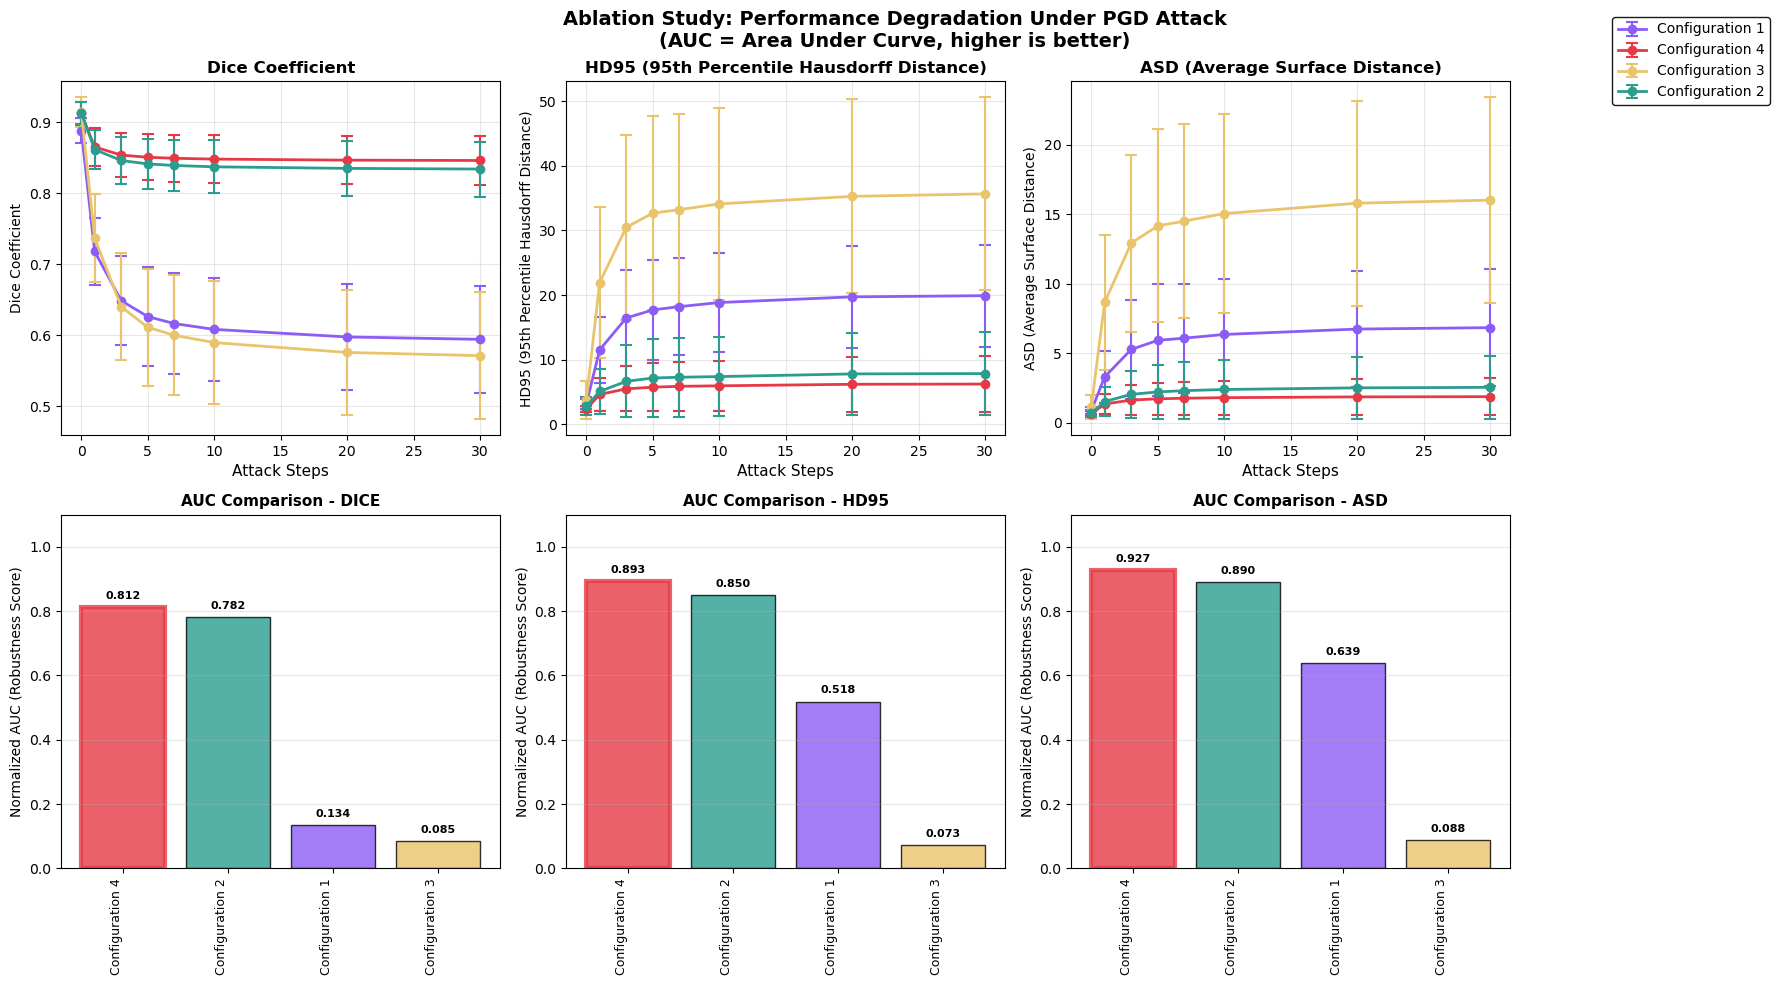

Saved auc_degradation_plot_ablation_study.png


In [ ]:
from sklearn.metrics import auc
import numpy as np
import pandas as pd

# Load ablation study data
ablation_base_dir = Path("path/to/ablation/study/results")
ablation_files = {
    "dice": ablation_base_dir / "ablation_study_dice_results.csv",
    "hd95": ablation_base_dir / "ablation_study_hd95_results.csv",
    "asd": ablation_base_dir / "ablation_study_asd_results.csv"
}

# Load and combine ablation data
ablation_dfs = []
for metric, filepath in ablation_files.items():
    df = pd.read_csv(filepath)
    df["metric"] = metric
    ablation_dfs.append(df)

ablation_df = pd.concat(ablation_dfs, ignore_index=True)

# Colors for each ablation configuration
ablation_colors = {
    'Configuration 4': '#E63946',
    'Configuration 2': '#2A9D8F',
    'Configuration 3': '#E9C46A',
    'Configuration 1': '#8B5CF6',
}

metric_labels = {
    "dice": "Dice Coefficient",
    "hd95": "HD95 (95th Percentile Hausdorff Distance)",
    "asd": "ASD (Average Surface Distance)"
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Ablation Study: Performance Degradation Under PGD Attack\n(AUC = Area Under Curve, higher is better)', 
             fontsize=14, fontweight='bold')

losses = ablation_df["loss"].dropna().unique()

for col, metric in enumerate(["dice", "hd95", "asd"]):
    ax_curve = axes[0, col]
    ax_auc = axes[1, col]
    
    metric_df = ablation_df[ablation_df["metric"] == metric]
    steps = sorted(metric_df["steps"].dropna().unique())
    
    # First pass: collect all data and find global min/max for proper normalization
    loss_data = {}
    global_min = float('inf')
    global_max = float('-inf')
    
    for loss in losses:
        loss_df = metric_df[metric_df["loss"] == loss]
        
        # Get mean values and SEM for each step (aggregate across folds)
        step_means = []
        step_sems = []
        valid_steps = []
        for step in steps:
            step_data = loss_df[loss_df["steps"] == step]
            # Average across folds
            step_val = step_data["mean"].mean()
            # Pool SEM across folds
            if "sem" in step_data.columns:
                sem_values = pd.to_numeric(step_data["sem"], errors='coerce')
                step_sem = sem_values.mean()
            else:
                step_sem = 0
            if not np.isnan(step_val):
                step_means.append(step_val)
                step_sems.append(step_sem if not np.isnan(step_sem) else 0)
                valid_steps.append(step)
        
        if len(valid_steps) >= 2:
            loss_data[loss] = {'steps': valid_steps, 'means': step_means, 'sems': step_sems}
            global_min = min(global_min, min(step_means))
            global_max = max(global_max, max(step_means))
    
    auc_values = {}
    
    # Second pass: calculate AUC with consistent normalization
    for loss, data in loss_data.items():
        valid_steps = data['steps']
        step_means = data['means']
        step_sems = data['sems']
        
        color = ablation_colors.get(loss, '#888888')
        label = ablation_labels.get(loss, loss)
        
        # Calculate 95% CI (mean ± 1.96 * SEM)
        ci_95 = [1.96 * sem for sem in step_sems]
        
        # Plot degradation curve with 95% CI error bars
        ax_curve.errorbar(valid_steps, step_means, yerr=ci_95, fmt='o-', color=color, 
                         linewidth=2, markersize=6, capsize=4, capthick=1.5, elinewidth=1.5,
                         label=label)
        
        # Normalize steps to 0-1 for fair comparison
        steps_norm = np.array(valid_steps) / max(valid_steps)
        
        # Calculate AUC with proper normalization
        if metric == "dice":
            if global_max > global_min:
                normalized_means = [(v - global_min) / (global_max - global_min) for v in step_means]
            else:
                normalized_means = step_means
            auc_val = auc(steps_norm, normalized_means)
        else:
            # For HD95/ASD: invert using global max so higher AUC = more robust
            if global_max > global_min:
                inverted_means = [(global_max - v) / (global_max - global_min) for v in step_means]
            else:
                inverted_means = [1.0 for _ in step_means]
            auc_val = auc(steps_norm, inverted_means)
        
        auc_values[loss] = auc_val
    
    # Configure curve plot
    ax_curve.set_xlabel('Attack Steps', fontsize=11)
    ax_curve.set_ylabel(metric_labels[metric], fontsize=10)
    ax_curve.set_title(f'{metric_labels[metric]}', fontsize=12, fontweight='bold')
    ax_curve.grid(True, alpha=0.3)
    
    # Plot AUC bar chart (sorted by AUC, higher is better for all metrics now)
    sorted_losses = sorted(auc_values.keys(), key=lambda x: auc_values[x], reverse=True)
    colors = [ablation_colors.get(l, '#888888') for l in sorted_losses]
    auc_vals = [auc_values[l] for l in sorted_losses]
    
    bars = ax_auc.bar(range(len(sorted_losses)), auc_vals, color=colors, alpha=0.8, edgecolor='black')
    ax_auc.set_xticks(range(len(sorted_losses)))
    ax_auc.set_xticklabels([ablation_labels.get(l, l) for l in sorted_losses], 
                           rotation=90, ha='right', fontsize=9)
    ax_auc.set_ylabel('Normalized AUC (Robustness Score)', fontsize=10)
    ax_auc.set_title(f'AUC Comparison - {metric.upper()}', fontsize=11, fontweight='bold')
    ax_auc.grid(True, axis='y', alpha=0.3)
    ax_auc.set_ylim(0, 1.1)
    
    # Add value labels on bars
    for bar, val in zip(bars, auc_vals):
        ax_auc.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Highlight RAR-Loss (Full) bar
    if 'RAR-Loss (Full)' in sorted_losses:
        rar_idx = sorted_losses.index('RAR-Loss (Full)')
        bars[rar_idx].set_edgecolor('#E63946')
        bars[rar_idx].set_linewidth(3)

# Add single legend for all curves in top right corner
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.99, 0.98),
          fontsize=10, framealpha=0.9, edgecolor='black')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('auc_degradation_plot_ablation_study.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved auc_degradation_plot_ablation_study.png")